**Objective**: quantify the performance difference between more engaged organizations and less engaged

It is apparent in almost every comparison that organizations with greater engagement (utilizing more features, logging in more often, etc.) perform significantly better than organizations that are less engaged. We aim here to quantify this difference and ideally establish actionable recommendations to encourage greater engagement. This might be possible if we can establish initial features that might attract less engaged client who may become encouraged by a growth response, leading to further engagement.

**Secondary**: datapoints here will prove useful for the growth opportunities report

**Process**:

1. establish a definition in order distinguish between more and less engaged organizations; this could be a set of features adopted, and, if so, 
    1. which are the most prominent and highly correlated with greater performance, and
    2. which are the most common among the more engaged and least common among the less engaged
2. attempt to define an average timeline of feature adoption

In [1]:
import pandas as pd
import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

# loading data

In [2]:
# transactions - load by org, month
q = '''select
            org,
            date_trunc('month', date) as month,
            count(id) as count,
            sum(amount) as vol
        from transactions
            where status='A' and date>'2020-01-01'
        group by org, date_trunc('month', date)'''
trans = redshift_query_read(q)
trans['month'] = pd.to_datetime(trans['month']).dt.to_period('M')

In [3]:
trans.head(3)

,org,month,count,vol
0,442323,2020-01,69,6995.12
1,1215,2020-01,51,3274.87
2,437302,2020-01,259,19845.60


In [4]:
# badges
q = "select distinct(org) from logs where systemtype=25"
badges = redshift_query_read(q)['org'].tolist()
"{} badges orgs".format(len(badges))

'897 badges orgs'

In [5]:
# segment users created
q = "select id as users_created, uuid, org, name, timestamp 'epoch' + created_at * interval '1 second' as month, user_type, total_forms, donation_forms, status, p2p_events, political_forms from users order by created_at desc"
users = redshift_query_read(q, schema='secure')
users['month'] = pd.to_datetime(users['month']).dt.to_period('M')
users = users.groupby(['org', 'month'])['users_created'].count().reset_index()
"{} users created orgs".format(len(users['org'].unique()))

'3967 users created orgs'

In [6]:
users.head(3)

,org,month,users_created
0,0,2015-03,1
1,0,2015-04,1
2,100355,2014-07,1


In [7]:
# segment logins (since 01/2020)
q = '''select 
            count(user_id) as logins,
            users.org, 
            date_trunc('month', original_timestamp) as month 
        from login 
            left join users on login.user_id=users._id
        group by org, date_trunc('month', original_timestamp)'''
logins = redshift_query_read(q, schema='secure')
logins['month'] = pd.to_datetime(logins['month']).dt.to_period('M')
"{} logins orgs".format(len(logins['org'].unique()))

'3222 logins orgs'

In [8]:
# segment logins (last 6 months)
q = '''select 
            count(user_id) as logins,
            users.org, 
            date_trunc('month', original_timestamp) as month 
        from login 
            left join users on login.user_id=users._id
        where original_timestamp>=dateadd(month, -6, CURRENT_DATE)
        group by org, date_trunc('month', original_timestamp)'''
logins_six_months = redshift_query_read(q, schema='secure')
logins_six_months['month'] = pd.to_datetime(logins_six_months['month']).dt.to_period('M')
"{} logins orgs".format(len(logins_six_months['org'].unique()))

'2969 logins orgs'

In [9]:
# segment logins (last 3 months)
q = '''select 
            count(user_id) as logins,
            users.org, 
            date_trunc('month', original_timestamp) as month 
        from login 
            left join users on login.user_id=users._id
        where original_timestamp>=dateadd(month, -3, CURRENT_DATE)
        group by org, date_trunc('month', original_timestamp)'''
logins_three_months = redshift_query_read(q, schema='secure')
logins_three_months['month'] = pd.to_datetime(logins_three_months['month']).dt.to_period('M')
"{} logins orgs".format(len(logins_three_months['org'].unique()))

'2613 logins orgs'

In [10]:
# segment logins (last 1 month)
q = '''select 
            count(user_id) as logins,
            users.org, 
            date_trunc('month', original_timestamp) as month 
        from login 
            left join users on login.user_id=users._id
        where original_timestamp>=dateadd(month, -1, CURRENT_DATE)
        group by org, date_trunc('month', original_timestamp)'''
logins_one_months = redshift_query_read(q, schema='secure')
logins_one_months['month'] = pd.to_datetime(logins_one_months['month']).dt.to_period('M')
"{} logins orgs".format(len(logins_one_months['org'].unique()))

'2171 logins orgs'

In [11]:
# segment integrations
q = '''select 
            users.org as org,
            count(activated_integration.id) as integrations, 
            date_trunc('month', original_timestamp) as month 
        from activated_integration
            left join users on activated_integration.uuid=users.uuid
        group by month, org'''
integrations = redshift_query_read(q, schema='secure')
integrations['month'] = pd.to_datetime(integrations['month']).dt.to_period('M')
"{} integrations orgs".format(len(integrations['org'].unique()))

'55 integrations orgs'

In [12]:
# segment cms
q = '''select
            users.org as org,
            count(saved_page.id) as page_updates,
            date_trunc('month', original_timestamp) as month
        from saved_page
            left join users on saved_page.uuid=users.uuid
        group by month, org'''
cms = redshift_query_read(q, schema='secure')
cms['month'] = pd.to_datetime(cms['month']).dt.to_period('M')
"{} CMS orgs".format(len(cms['org'].unique()))

'2473 CMS orgs'

In [13]:
# segment widgets
q = '''select
            users.org as org,
            count(created_widget.id) as widgets_created,
            date_trunc('month', original_timestamp) as month
        from created_widget
            left join users on created_widget.uuid=users.uuid
        group by month, org'''
widgets = redshift_query_read(q, schema='secure')
widgets['month'] = pd.to_datetime(widgets['month']).dt.to_period('M')
"{} created widgets orgs".format(len(widgets['org'].unique()))

'68 created widgets orgs'

In [14]:
# segment goals
q = '''select 
            users.org as org,
            count(goals_saved_item_settings.id) as goals_saved, 
            date_trunc('month', original_timestamp) as month 
        from goals_saved_item_settings
            left join users on goals_saved_item_settings.uuid=users.uuid
        group by month, org'''
goals_saved = redshift_query_read(q, schema="secure")
goals_saved['month'] = pd.to_datetime(goals_saved['month']).dt.to_period('M')
"{} goals saved orgs".format(len(goals_saved['org'].unique()))

'55 goals saved orgs'

In [15]:
# segment fundhub
q = "select users.org as org, count(accessed_fund_hub_builder.id) as fundhub_builder_accessed, date_trunc('month', original_timestamp) as month from accessed_fund_hub_builder left join users on accessed_fund_hub_builder.uuid=users.uuid group by month, org"
fundhub_accessed = redshift_query_read(q, schema="secure")
q = "select users.org as org, count(accessed_event_builder.id) as event_builder_accessed, date_trunc('month', original_timestamp) as month from accessed_event_builder left join users on accessed_event_builder.uuid=users.uuid group by month, org"
eventbuilder_accessed = redshift_query_read(q, schema="secure")
q = "select users.org as org, count(accessed_form_builder.id) as form_builder_accessed, date_trunc('month', original_timestamp) as month from accessed_form_builder left join users on accessed_form_builder.uuid=users.uuid group by month, org"
formbuilder_accessed = redshift_query_read(q, schema="secure")

fundhub = fundhub_accessed.merge(eventbuilder_accessed, on=['org', 'month'], how='outer')
fundhub = fundhub.merge(formbuilder_accessed, on=['org', 'month'], how='outer').fillna(0)
fundhub['month'] = pd.to_datetime(fundhub['month']).dt.to_period('M')

"{} fundhub orgs".format(len(fundhub['org'].unique()))

'2144 fundhub orgs'

In [16]:
# auctions
q = "select form, org from transactions"
forms_orgs = redshift_query_read(q)
q = "select * from transauction"
auctions_forms = redshift_query_read(q, schema="production")['form'].unique().tolist()
auctions = forms_orgs[forms_orgs['form'].isin(auctions_forms)]['org'].unique().tolist()
"{} auctions orgs".format(len(auctions))

'137 auctions orgs'

In [17]:
# thermometers
q = "select form from thermometers"
therms_forms = redshift_query_read(q, schema="production")['form'].unique().tolist()
therms = forms_orgs[forms_orgs['form'].isin(therms_forms)]['org'].unique().tolist()

In [18]:
# lists
q = "select distinct(creatingentity) as org from lists"
lists = redshift_query_read(q, schema="production")['org'].unique().tolist()

In [19]:
# sms campaign
q = "select distinct(entity) as org from smscampaign"
smscampaigns = redshift_query_read(q, schema="production")['org'].unique().tolist()

In [20]:
# recurring
q = "select distinct(org) as org from transactions where recurring!=0"
recurring = redshift_query_read(q)['org'].unique().astype(int).tolist()

In [21]:
# sources
q = "select org, source from transactions group by org, source"
sources = redshift_query_read(q)

In [22]:
# donor logins
df_dl_trans = get_dataframe_from_file("qgiv-stats-data", "dl_transactions.csv")
donorlogins = df_dl_trans['org'].unique().astype(int).tolist()

## merging data

In [23]:
# merging feature data
cols = ['org', 'month']
mrgd = users.merge(logins, on=cols, how='outer').merge(integrations, on=cols, how='outer')
mrgd = mrgd.merge(cms, on=cols, how='outer').merge(widgets, on=cols, how='outer')
mrgd = mrgd.merge(goals_saved, on=cols, how='outer').merge(fundhub, on=cols, how='outer')
mrgd.fillna(0, inplace=True)

mrgd['org'] = mrgd['org'].astype(int)

mrgd['auctions'] = mrgd['org'].isin(auctions).astype(int)
mrgd['badges'] = mrgd['org'].isin(badges).astype(int)
mrgd['thermometers'] = mrgd['org'].isin(therms).astype(int)
mrgd['lists'] = mrgd['org'].isin(lists).astype(int)
mrgd['smscampaigns'] = mrgd['org'].isin(smscampaigns).astype(int)
for source in sources['source'].unique().tolist():
    mrgd['source_{}'.format(source)] = mrgd['org'].astype(int).isin(sources[sources['source']==source]['org'].astype(int)).astype(int)
mrgd['recurring'] = mrgd['org'].isin(recurring).astype(int)
mrgd['donorlogins'] = mrgd['org'].isin(donorlogins).astype(int)

mrgd['logins_six_months'] = mrgd['org'].isin(logins_six_months['org'].unique().astype(int).tolist()).astype(int)
mrgd['logins_three_months'] = mrgd['org'].isin(logins_three_months['org'].unique().astype(int).tolist()).astype(int)
mrgd['logins_one_months'] = mrgd['org'].isin(logins_one_months['org'].unique().astype(int).tolist()).astype(int)

In [24]:
mrgd.head(3)

,org,month,users_created,logins,integrations,page_updates,widgets_created,goals_saved,fundhub_builder_accessed,event_builder_accessed,...,source_mobile,source_mobilevt,source_sms,source_fb,source_givi,recurring,donorlogins,logins_six_months,logins_three_months,logins_one_months
0,0,2015-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,0
1,0,2015-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,0
2,100355,2014-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,1,1,1


In [25]:
len(mrgd[mrgd['logins']>0]), len(mrgd[mrgd['integrations']>0]), len(mrgd[mrgd['page_updates']>0]), len(mrgd[mrgd['widgets_created']>0])

(19391, 82, 3012, 90)

In [26]:
trans_data = None
for org in trans['org'].unique():
    _trans = trans[trans['org']==org].copy().sort_values('month', ascending=True)
    _trans['vol_diff'] = _trans['vol'] - _trans['vol'].shift(1)
    _trans['vol_diff_perc'] = _trans['vol'].pct_change()
    _trans['per_trans'] = _trans['vol'] / _trans['count']
    
    if trans_data is None:
        trans_data = _trans
    else:
        trans_data = trans_data.append(_trans)

In [27]:
trans_data.head()

,org,month,count,vol,vol_diff,vol_diff_perc,per_trans
0,442323,2020-01,69,6995.12,NaN,NaN,101.378551
5073,442323,2020-02,70,8424.70,1429.58,0.204368,120.352857
1577,442323,2020-03,263,42984.00,34559.30,4.102140,163.437262
1926,442323,2020-04,78,18367.00,-24617.00,-0.572701,235.474359
5280,442323,2020-05,68,8681.70,-9685.30,-0.527321,127.672059


In [28]:
mrgd['org'] = mrgd['org'].astype(int)
trans_data['org'] = trans_data['org'].astype(int)
all_mrgd = trans_data.merge(mrgd, on=['org', 'month'], how='outer')

# correlations
## time based correlation

In [29]:
all_mrgd[[c for c in all_mrgd.columns if 'source' not in c]].corr()

,org,count,vol,vol_diff,vol_diff_perc,per_trans,users_created,logins,integrations,page_updates,...,auctions,badges,thermometers,lists,smscampaigns,recurring,donorlogins,logins_six_months,logins_three_months,logins_one_months
org,1.000000,-0.005686,0.003106,0.000102,0.031271,0.003744,0.040906,0.005431,-0.027966,-0.031798,...,0.063220,0.137094,0.078218,0.048766,0.058263,-0.299055,-0.249257,-0.064479,-0.076591,-0.082821
count,-0.005686,1.000000,0.024653,0.004821,0.008205,-0.000687,0.052225,0.474607,0.020648,0.034053,...,0.003305,0.106825,0.051305,0.020021,0.019904,0.032257,0.092663,0.023970,0.035691,0.053982
vol,0.003106,0.024653,1.000000,0.706935,0.083499,0.999291,-0.000287,0.011207,0.000295,-0.000551,...,-0.001501,-0.001175,-0.002623,-0.000986,-0.000920,0.004890,-0.003266,0.002210,0.003345,0.005217
vol_diff,0.000102,0.004821,0.706935,1.000000,0.059514,0.706838,0.000699,0.002644,0.000097,-0.000033,...,0.000055,0.000011,-0.000086,-0.000082,-0.000059,-0.000111,-0.000129,-0.000013,-0.000017,-0.000008
vol_diff_perc,0.031271,0.008205,0.083499,0.059514,1.000000,0.083958,0.096217,0.073627,-0.001868,-0.010622,...,0.069351,0.007911,-0.009177,-0.008364,0.007314,-0.071655,-0.041874,0.007013,-0.005029,-0.011213
per_trans,0.003744,-0.000687,0.999291,0.706838,0.083958,1.000000,-0.002082,-0.003217,-0.000247,-0.001532,...,-0.001635,-0.004222,-0.004973,-0.001368,-0.001380,0.003125,-0.007165,0.001173,0.002070,0.003179
users_created,0.040906,0.052225,-0.000287,0.000699,0.096217,-0.002082,1.000000,-0.063828,-0.005720,-0.008711,...,0.065347,0.090792,0.041992,0.024592,0.022657,-0.028229,-0.006316,-0.018532,-0.016532,-0.000631
logins,0.005431,0.474607,0.011207,0.002644,0.073627,-0.003217,-0.063828,1.000000,-0.003112,-0.006563,...,0.118670,0.223810,0.132769,0.043124,0.059551,0.087686,0.133493,0.148767,0.173126,0.206201
integrations,-0.027966,0.020648,0.000295,0.000097,-0.001868,-0.000247,-0.005720,-0.003112,1.000000,0.884071,...,-0.002354,-0.008240,-0.009458,-0.003205,-0.003186,0.009539,0.019945,-0.041056,-0.032629,-0.024713
page_updates,-0.031798,0.034053,-0.000551,-0.000033,-0.010622,-0.001532,-0.008711,-0.006563,0.884071,1.000000,...,-0.003311,-0.009790,-0.011008,-0.003260,-0.003272,0.010528,0.022399,-0.044743,-0.035703,-0.027156


In [30]:
drop_cols = ['org', 'month', 'count', 'vol', 'vol_diff', 'vol_diff_perc', 'per_trans']
all_mrgd.drop(drop_cols, axis=1).corr()

,users_created,logins,integrations,page_updates,widgets_created,goals_saved,fundhub_builder_accessed,event_builder_accessed,form_builder_accessed,auctions,...,source_mobile,source_mobilevt,source_sms,source_fb,source_givi,recurring,donorlogins,logins_six_months,logins_three_months,logins_one_months
users_created,1.000000,-0.063828,-0.005720,-0.008711,-0.007618,-0.007907,-0.006674,-0.009080,-0.008349,0.065347,...,-0.006741,0.045635,0.054359,0.019126,0.037365,-0.028229,-0.006316,-0.018532,-0.016532,-0.000631
logins,-0.063828,1.000000,-0.003112,-0.006563,-0.004762,-0.003810,-0.004070,-0.006375,-0.006326,0.118670,...,0.104243,0.079657,0.138697,0.113579,0.121730,0.087686,0.133493,0.148767,0.173126,0.206201
integrations,-0.005720,-0.003112,1.000000,0.884071,0.891850,0.844618,0.000226,-0.000262,-0.000225,-0.002354,...,-0.018766,-0.006361,-0.009842,-0.005189,-0.004519,0.009539,0.019945,-0.041056,-0.032629,-0.024713
page_updates,-0.008711,-0.006563,0.884071,1.000000,0.990632,0.923643,-0.000281,-0.000338,-0.000310,-0.003311,...,-0.020903,-0.008350,-0.011728,-0.005704,-0.005295,0.010528,0.022399,-0.044743,-0.035703,-0.027156
widgets_created,-0.007618,-0.004762,0.891850,0.990632,1.000000,0.902901,0.000121,-0.000302,-0.000255,-0.003084,...,-0.020988,-0.007946,-0.011508,-0.005773,-0.005265,0.010770,0.022601,-0.045491,-0.036163,-0.027424
goals_saved,-0.007907,-0.003810,0.844618,0.923643,0.902901,1.000000,-0.000017,-0.000282,-0.000249,-0.002328,...,-0.018365,-0.006269,-0.009660,-0.005076,-0.004431,0.009338,0.019529,-0.040139,-0.031902,-0.024166
fundhub_builder_accessed,-0.006674,-0.004070,0.000226,-0.000281,0.000121,-0.000017,1.000000,0.895064,0.910533,-0.002799,...,-0.019117,-0.007216,-0.010475,-0.005250,-0.004786,0.009793,0.020566,-0.041423,-0.032932,-0.024977
event_builder_accessed,-0.009080,-0.006375,-0.000262,-0.000338,-0.000302,-0.000282,0.895064,1.000000,0.992485,-0.003261,...,-0.021106,-0.008228,-0.011679,-0.005758,-0.005364,0.010363,0.022348,-0.045802,-0.036507,-0.027784
form_builder_accessed,-0.008349,-0.006326,-0.000225,-0.000310,-0.000255,-0.000249,0.910533,0.992485,1.000000,-0.003338,...,-0.020749,-0.008334,-0.011730,-0.005685,-0.005317,0.010772,0.022526,-0.044548,-0.035433,-0.026917
auctions,0.065347,0.118670,-0.002354,-0.003311,-0.003084,-0.002328,-0.002799,-0.003261,-0.003338,1.000000,...,-0.014539,0.040467,0.051104,0.069829,0.618686,-0.073495,-0.030611,0.059619,0.054433,0.069728


## lifetime averages correlations

In [31]:
ftr_cols = [col for col in all_mrgd.columns if col not in drop_cols]
org_lifetime_avg = all_mrgd.fillna(0).groupby('org').mean().reset_index()

In [32]:
org_lifetime_avg[ftr_cols].corr()

,users_created,logins,integrations,page_updates,widgets_created,goals_saved,fundhub_builder_accessed,event_builder_accessed,form_builder_accessed,auctions,...,source_mobile,source_mobilevt,source_sms,source_fb,source_givi,recurring,donorlogins,logins_six_months,logins_three_months,logins_one_months
users_created,1.000000,0.321567,-0.004383,-0.013913,-0.010247,-0.004780,-0.010189,-0.012041,-0.014615,0.200076,...,-0.009885,0.068660,0.131178,0.049431,0.158077,-0.085871,-0.044074,0.123486,0.111484,0.127926
logins,0.321567,1.000000,-0.007383,-0.008896,-0.008039,-0.007426,-0.008046,-0.009738,-0.008428,0.267903,...,0.221493,0.132035,0.193418,0.200787,0.269795,0.237454,0.253523,0.403489,0.428819,0.461104
integrations,-0.004383,-0.007383,1.000000,0.997975,0.999377,0.999997,0.999393,0.998036,0.998094,-0.000552,...,-0.013769,-0.003065,-0.008110,-0.004401,-0.003264,0.019402,0.031883,-0.028005,-0.023428,-0.018860
page_updates,-0.013913,-0.008896,0.997975,1.000000,0.999554,0.998120,0.999542,0.999983,0.999990,-0.002809,...,-0.014349,-0.005855,-0.009087,-0.004308,-0.004430,0.017260,0.030308,-0.025658,-0.021744,-0.017673
widgets_created,-0.010247,-0.008039,0.999377,0.999554,1.000000,0.999455,0.999999,0.999567,0.999610,-0.001861,...,-0.013753,-0.004794,-0.008762,-0.004270,-0.003924,0.018672,0.031327,-0.026146,-0.021826,-0.017591
goals_saved,-0.004780,-0.007426,0.999997,0.998120,0.999455,1.000000,0.999469,0.998178,0.998234,-0.000636,...,-0.013784,-0.003176,-0.008159,-0.004395,-0.003303,0.019341,0.031839,-0.027874,-0.023318,-0.018777
fundhub_builder_accessed,-0.010189,-0.008046,0.999393,0.999542,0.999999,0.999469,1.000000,0.999555,0.999598,-0.001841,...,-0.013786,-0.004763,-0.008768,-0.004262,-0.003910,0.018652,0.031316,-0.026197,-0.021876,-0.017639
event_builder_accessed,-0.012041,-0.009738,0.998036,0.999983,0.999567,0.998178,0.999555,1.000000,0.999966,-0.002820,...,-0.014611,-0.005463,-0.008531,-0.004463,-0.004691,0.016595,0.029774,-0.028351,-0.023819,-0.019389
form_builder_accessed,-0.014615,-0.008428,0.998094,0.999990,0.999610,0.998234,0.999598,0.999966,1.000000,-0.002761,...,-0.013736,-0.005751,-0.009241,-0.004126,-0.004340,0.018087,0.030739,-0.024643,-0.020558,-0.016635
auctions,0.200076,0.267903,-0.000552,-0.002809,-0.001861,-0.000636,-0.001841,-0.002820,-0.002761,1.000000,...,-0.014561,0.027841,0.013571,0.049525,0.668182,-0.051983,-0.022817,0.128699,0.125889,0.125176


In [33]:
corr_df = org_lifetime_avg[ftr_cols].corr()

print("|     |  " + "| ".join(corr_df.columns) + " |")
print("|------" + "".join("|------" * len(corr_df.columns)) + "|")
for i, r in corr_df.iterrows():
    print("| " + " | ".join([i] + ["{:.1f}%".format(e * 100.) for e in list(r)]) + " |")

|     |  users_created| logins| integrations| page_updates| widgets_created| goals_saved| fundhub_builder_accessed| event_builder_accessed| form_builder_accessed| auctions| badges| thermometers| lists| smscampaigns| source_don_form| source_vt| source_p2p| source_kiosk| source_mobile| source_mobilevt| source_sms| source_fb| source_givi| recurring| donorlogins| logins_six_months| logins_three_months| logins_one_months |
|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| users_created | 100.0% | 32.2% | -0.4% | -1.4% | -1.0% | -0.5% | -1.0% | -1.2% | -1.5% | 20.0% | 21.6% | 11.2% | 3.0% | 5.9% | 29.4% | 11.7% | 21.3% | 0.9% | -1.0% | 6.9% | 13.1% | 4.9% | 15.8% | -8.6% | -4.4% | 12.3% | 11.1% | 12.8% |
| logins | 32.2% | 100.0% | -0.7% | -0.9% | -0.8% | -0.7% | -0.8% | -1.0% | -0.8% | 26.8% | 35.2% | 22.1% | 5.6% | 9.9% | 26.0% | 29.3%

|     |  users_created| logins| integrations| page_updates| widgets_created| goals_saved| fundhub_builder_accessed| event_builder_accessed| form_builder_accessed| auctions| badges| thermometers| lists| smscampaigns| source_don_form| source_vt| source_p2p| source_kiosk| source_mobile| source_mobilevt| source_fb| source_sms| source_givi| recurring| donorlogins| logins_six_months| logins_three_months| logins_one_months |
|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| users_created | 100.0% | 30.9% | -0.4% | -1.4% | -1.0% | -0.4% | -1.0% | -1.2% | -1.4% | 19.8% | 21.3% | 11.4% | 3.1% | 6.0% | 30.0% | 11.9% | 21.0% | 0.6% | -1.0% | 6.6% | 4.6% | 13.3% | 14.5% | -8.4% | -4.4% | 11.3% | 11.1% | 12.2% |
| logins | 30.9% | 100.0% | -0.7% | -0.9% | -0.8% | -0.7% | -0.8% | -1.0% | -0.8% | 26.7% | 35.3% | 22.3% | 5.7% | 10.0% | 26.0% | 29.5% | 34.2% | 3.8% | 22.3% | 13.3% | 20.3% | 19.3% | 26.9% | 24.1% | 25.6% | 40.4% | 43.1% | 45.7% |
| integrations | -0.4% | -0.7% | 100.0% | 99.8% | 99.9% | 100.0% | 99.9% | 99.8% | 99.8% | -0.0% | -0.7% | -0.8% | -0.3% | -0.3% | 1.2% | -1.8% | -0.8% | -0.1% | -1.4% | -0.3% | -0.4% | -0.8% | -0.3% | 1.9% | 3.2% | -2.8% | -2.4% | -1.9% |
| page_updates | -1.4% | -0.9% | 99.8% | 100.0% | 100.0% | 99.8% | 100.0% | 100.0% | 100.0% | -0.3% | -0.7% | -0.8% | -0.3% | -0.3% | 0.9% | -2.0% | -0.8% | -0.3% | -1.4% | -0.6% | -0.4% | -0.9% | -0.4% | 1.7% | 3.0% | -2.6% | -2.2% | -1.8% |
| widgets_created | -1.0% | -0.8% | 99.9% | 100.0% | 100.0% | 99.9% | 100.0% | 100.0% | 100.0% | -0.2% | -0.7% | -0.8% | -0.3% | -0.3% | 1.0% | -1.9% | -0.8% | -0.2% | -1.4% | -0.5% | -0.4% | -0.9% | -0.4% | 1.9% | 3.1% | -2.6% | -2.2% | -1.8% |
| goals_saved | -0.4% | -0.7% | 100.0% | 99.8% | 99.9% | 100.0% | 99.9% | 99.8% | 99.8% | -0.0% | -0.7% | -0.8% | -0.3% | -0.3% | 1.2% | -1.8% | -0.8% | -0.1% | -1.4% | -0.3% | -0.4% | -0.8% | -0.3% | 1.9% | 3.2% | -2.8% | -2.4% | -1.9% |
| fundhub_builder_accessed | -1.0% | -0.8% | 99.9% | 100.0% | 100.0% | 99.9% | 100.0% | 100.0% | 100.0% | -0.2% | -0.7% | -0.8% | -0.3% | -0.3% | 1.0% | -1.9% | -0.8% | -0.2% | -1.4% | -0.5% | -0.4% | -0.9% | -0.4% | 1.9% | 3.1% | -2.6% | -2.2% | -1.8% |
| event_builder_accessed | -1.2% | -1.0% | 99.8% | 100.0% | 100.0% | 99.8% | 100.0% | 100.0% | 100.0% | -0.3% | -0.7% | -0.8% | -0.3% | -0.3% | 1.0% | -1.9% | -0.7% | -0.3% | -1.5% | -0.5% | -0.4% | -0.9% | -0.5% | 1.7% | 3.0% | -2.8% | -2.4% | -1.9% |
| form_builder_accessed | -1.4% | -0.8% | 99.8% | 100.0% | 100.0% | 99.8% | 100.0% | 100.0% | 100.0% | -0.3% | -0.8% | -0.8% | -0.3% | -0.3% | 0.9% | -2.0% | -0.8% | -0.3% | -1.4% | -0.6% | -0.4% | -0.9% | -0.4% | 1.8% | 3.1% | -2.5% | -2.1% | -1.7% |
| auctions | 19.8% | 26.7% | -0.0% | -0.3% | -0.2% | -0.0% | -0.2% | -0.3% | -0.3% | 100.0% | 5.4% | 1.4% | 4.3% | 6.2% | 9.6% | 14.8% | 4.6% | 0.1% | -1.8% | 3.1% | 4.1% | 1.2% | 66.3% | -5.2% | -2.3% | 12.6% | 12.2% | 12.5% |
| badges | 21.3% | 35.3% | -0.7% | -0.7% | -0.7% | -0.7% | -0.7% | -0.7% | -0.8% | 5.4% | 100.0% | 12.3% | 5.6% | 8.5% | 15.4% | 31.2% | 94.5% | -4.1% | 1.9% | 6.9% | 15.2% | 12.3% | 4.7% | 0.2% | 0.7% | 19.7% | 17.5% | 18.3% |
| thermometers | 11.4% | 22.3% | -0.8% | -0.8% | -0.8% | -0.8% | -0.8% | -0.8% | -0.8% | 1.4% | 12.3% | 100.0% | 11.1% | 9.8% | 15.9% | 15.2% | 12.6% | 1.5% | 23.7% | 12.3% | 9.6% | 30.0% | 2.2% | 18.8% | 17.0% | 18.6% | 19.3% | 19.3% |
| lists | 3.1% | 5.7% | -0.3% | -0.3% | -0.3% | -0.3% | -0.3% | -0.3% | -0.3% | 4.3% | 5.6% | 11.1% | 100.0% | 73.6% | -0.2% | -0.5% | 4.0% | 0.5% | 2.2% | 4.1% | 0.4% | 23.6% | 4.2% | -1.1% | 0.5% | 5.4% | 2.1% | 2.2% |
| smscampaigns | 6.0% | 10.0% | -0.3% | -0.3% | -0.3% | -0.3% | -0.3% | -0.3% | -0.3% | 6.2% | 8.5% | 9.8% | 73.6% | 100.0% | 1.6% | 2.0% | 6.9% | 0.6% | 1.7% | 4.1% | 1.1% | 22.7% | 5.0% | -0.6% | -0.0% | 7.8% | 5.6% | 5.4% |
| source_don_form | 30.0% | 26.0% | 1.2% | 0.9% | 1.0% | 1.2% | 1.0% | 1.0% | 0.9% | 9.6% | 15.4% | 15.9% | -0.2% | 1.6% | 100.0% | 24.8% | 16.1% | 5.8% | 26.1% | 13.6% | 10.0% | 13.2% | 10.9% | 22.3% | 16.4% | 39.8% | 38.0% | 36.9% |
| source_vt | 11.9% | 29.5% | -1.8% | -2.0% | -1.9% | -1.8% | -1.9% | -1.9% | -2.0% | 14.8% | 31.2% | 15.2% | -0.5% | 2.0% | 24.8% | 100.0% | 32.0% | 12.3% | 33.0% | 22.3% | 16.6% | 13.2% | 14.6% | 36.9% | 28.1% | 24.8% | 26.9% | 27.7% |
| source_p2p | 21.0% | 34.2% | -0.8% | -0.8% | -0.8% | -0.8% | -0.8% | -0.7% | -0.8% | 4.6% | 94.5% | 12.6% | 4.0% | 6.9% | 16.1% | 32.0% | 100.0% | -2.9% | 2.5% | 7.3% | 15.7% | 12.5% | 4.0% | 1.0% | 2.0% | 19.6% | 17.8% | 18.5% |
| source_kiosk | 0.6% | 3.8% | -0.1% | -0.3% | -0.2% | -0.1% | -0.2% | -0.3% | -0.3% | 0.1% | -4.1% | 1.5% | 0.5% | 0.6% | 5.8% | 12.3% | -2.9% | 100.0% | 14.2% | 16.9% | 6.1% | 10.7% | 7.1% | 16.9% | 20.9% | 6.8% | 6.7% | 8.0% |
| source_mobile | -1.0% | 22.3% | -1.4% | -1.4% | -1.4% | -1.4% | -1.4% | -1.5% | -1.4% | -1.8% | 1.9% | 23.7% | 2.2% | 1.7% | 26.1% | 33.0% | 2.5% | 14.2% | 100.0% | 24.4% | 15.9% | 15.4% | 4.6% | 49.7% | 40.0% | 29.7% | 32.5% | 34.1% |
| source_mobilevt | 6.6% | 13.3% | -0.3% | -0.6% | -0.5% | -0.3% | -0.5% | -0.5% | -0.6% | 3.1% | 6.9% | 12.3% | 4.1% | 4.1% | 13.6% | 22.3% | 7.3% | 16.9% | 24.4% | 100.0% | 13.8% | 16.1% | 7.5% | 21.7% | 21.4% | 15.3% | 16.0% | 17.5% |
| source_fb | 4.6% | 20.3% | -0.4% | -0.4% | -0.4% | -0.4% | -0.4% | -0.4% | -0.4% | 4.1% | 15.2% | 9.6% | 0.4% | 1.1% | 10.0% | 16.6% | 15.7% | 6.1% | 15.9% | 13.8% | 100.0% | 14.2% | 6.1% | 17.8% | 20.7% | 14.0% | 15.6% | 15.8% |
| source_sms | 13.3% | 19.3% | -0.8% | -0.9% | -0.9% | -0.8% | -0.9% | -0.9% | -0.9% | 1.2% | 12.3% | 30.0% | 23.6% | 22.7% | 13.2% | 13.2% | 12.5% | 10.7% | 15.4% | 16.1% | 14.2% | 100.0% | 3.2% | 10.6% | 12.4% | 8.7% | 9.6% | 10.9% |
| source_givi | 14.5% | 26.9% | -0.3% | -0.4% | -0.4% | -0.3% | -0.4% | -0.5% | -0.4% | 66.3% | 4.7% | 2.2% | 4.2% | 5.0% | 10.9% | 14.6% | 4.0% | 7.1% | 4.6% | 7.5% | 6.1% | 3.2% | 100.0% | 3.5% | 9.4% | 15.9% | 16.2% | 16.4% |
| recurring | -8.4% | 24.1% | 1.9% | 1.7% | 1.9% | 1.9% | 1.9% | 1.7% | 1.8% | -5.2% | 0.2% | 18.8% | -1.1% | -0.6% | 22.3% | 36.9% | 1.0% | 16.9% | 49.7% | 21.7% | 17.8% | 10.6% | 3.5% | 100.0% | 53.7% | 36.9% | 40.5% | 41.2% |
| donorlogins | -4.4% | 25.6% | 3.2% | 3.0% | 3.1% | 3.2% | 3.1% | 3.0% | 3.1% | -2.3% | 0.7% | 17.0% | 0.5% | -0.0% | 16.4% | 28.1% | 2.0% | 20.9% | 40.0% | 21.4% | 20.7% | 12.4% | 9.4% | 53.7% | 100.0% | 27.2% | 29.6% | 32.1% |
| logins_six_months | 11.3% | 40.4% | -2.8% | -2.6% | -2.6% | -2.8% | -2.6% | -2.8% | -2.5% | 12.6% | 19.7% | 18.6% | 5.4% | 7.8% | 39.8% | 24.8% | 19.6% | 6.8% | 29.7% | 15.3% | 14.0% | 8.7% | 15.9% | 36.9% | 27.2% | 100.0% | 86.2% | 73.3% |
| logins_three_months | 11.1% | 43.1% | -2.4% | -2.2% | -2.2% | -2.4% | -2.2% | -2.4% | -2.1% | 12.2% | 17.5% | 19.3% | 2.1% | 5.6% | 38.0% | 26.9% | 17.8% | 6.7% | 32.5% | 16.0% | 15.6% | 9.6% | 16.2% | 40.5% | 29.6% | 86.2% | 100.0% | 84.4% |
| logins_one_months | 12.2% | 45.7% | -1.9% | -1.8% | -1.8% | -1.9% | -1.8% | -1.9% | -1.7% | 12.5% | 18.3% | 19.3% | 2.2% | 5.4% | 36.9% | 27.7% | 18.5% | 8.0% | 34.1% | 17.5% | 15.8% | 10.9% | 16.4% | 41.2% | 32.1% | 73.3% | 84.4% | 100.0% |

There does not appear to be a strong correlation between any given feature and overall performance. The overall volume appears to be -0.05% across the board. Logins on the other hand has a 50% correlation to transaction counts and 16% correlation to volume difference percentage, which is interesting but most likely an anomaly. Even if it is true, there is no practical association that can be made (logging in more frequently will obvioulsy not drive greater fundraising).

**There is a clear, strong relationship between the utilization of features. It does appear that organizations likely to engage with one of these features is highly likely to engage with the others.**

The association between logins and processing is however further evidence of what we are trying to measure here so that is a good sign. Let's establish a line between organizations with frequent logins and non-freuqent logins to examine average feature usage between the two.

# frequent login feature usage

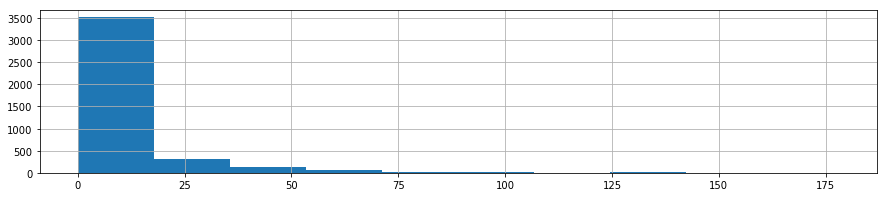

In [34]:
org_lifetime_avg['logins'].hist(figsize=(15,3))

# zendesk

In [35]:
zd = get_dataframe_from_file("qgiv-stats-data", "zendesk.mrgd.csv")
zd = zd[['external_id', 'created_at', 'updated_at']]
zd = zd[zd['external_id'].apply(lambda x: str(x).isnumeric())]
zd['org'] = zd['external_id'].astype(int, errors='ignore')
zd.drop('external_id', axis=1, inplace=True)
zd['created_at'] = pd.to_datetime(zd['created_at'])

In [36]:
org_lifetime_avg['zendesk'] = org_lifetime_avg['org'].astype(int).isin(zd['org'].astype(int).tolist()).astype(int)

## feature medians & counts

In [37]:
ftr_cols = [col for col in org_lifetime_avg.columns if col not in drop_cols]

print("| Feature | Median Volume Active | Median Volume Inactive | Count | Percentage |")
print("|---------|:--------------------:|:----------------------:|:-----:|:----------:|")

for ftr in sorted(ftr_cols):
    mdn_active = org_lifetime_avg[org_lifetime_avg[ftr]>0.]['vol'].median()
    mdn_inactive = org_lifetime_avg[org_lifetime_avg[ftr]==0.]['vol'].median()
    count = len(org_lifetime_avg[org_lifetime_avg[ftr]>0.])
    perc = (float(count) / float(len(org_lifetime_avg))) * 100.
    print("| {} | \${:,.2f} | \${:,.2f} | {} | {:.2f}% |".format(ftr, mdn_active, mdn_inactive, count, perc))

| Feature | Median Volume Active | Median Volume Inactive | Count | Percentage |
|---------|:--------------------:|:----------------------:|:-----:|:----------:|
| auctions | \$3,205.29 | \$352.85 | 134 | 3.31% |
| badges | \$2,041.36 | \$270.41 | 793 | 19.56% |
| donorlogins | \$2,328.18 | \$153.33 | 1027 | 25.33% |
| event_builder_accessed | \$153.33 | \$698.04 | 2143 | 52.86% |
| form_builder_accessed | \$840.18 | \$376.64 | 288 | 7.10% |
| fundhub_builder_accessed | \$1,154.45 | \$394.22 | 66 | 1.63% |
| goals_saved | \$762.75 | \$396.23 | 55 | 1.36% |
| integrations | \$762.75 | \$396.23 | 55 | 1.36% |
| lists | \$243.02 | \$401.64 | 124 | 3.06% |
| logins | \$830.05 | \$0.00 | 3222 | 79.48% |
| logins_one_months | \$1,842.24 | \$8.40 | 2171 | 53.55% |
| logins_six_months | \$998.05 | \$0.00 | 2969 | 73.24% |
| logins_three_months | \$1,304.83 | \$0.00 | 2613 | 64.45% |
| page_updates | \$183.18 | \$742.04 | 2472 | 60.98% |
| recurring | \$1,140.38 | \$10.32 | 2312 | 57.03% |
| sm

| Feature | Median Volume Active | Median Volume Inactive | Count | Percentage |
|---------|:--------------------:|:----------------------:|:-----:|:----------:|
| auctions | \$3,186.42 | \$344.31 | 129 | 3.19% |
| badges | \$1,972.74 | \$267.17 | 786 | 19.45% |
| donorlogins | \$2,284.41 | \$148.92 | 1023 | 25.31% |
| event_builder_accessed | \$153.10 | \$665.14 | 2084 | 51.56% |
| form_builder_accessed | \$1,153.86 | \$364.23 | 251 | 6.21% |
| fundhub_builder_accessed | \$1,146.30 | \$383.09 | 66 | 1.63% |
| goals_saved | \$762.75 | \$387.22 | 55 | 1.36% |
| integrations | \$762.75 | \$387.22 | 55 | 1.36% |
| lists | \$243.02 | \$396.32 | 124 | 3.07% |
| logins | \$813.62 | \$0.00 | 3208 | 79.37% |
| logins_one_months | \$1,729.49 | \$7.08 | 2184 | 54.03% |
| logins_six_months | \$996.75 | \$0.00 | 2962 | 73.28% |
| logins_three_months | \$1,295.25 | \$0.00 | 2615 | 64.70% |
| page_updates | \$181.62 | \$729.07 | 2472 | 61.16% |
| recurring | \$1,129.12 | \$10.14 | 2307 | 57.08% |
| smscampaigns | \$1,038.73 | \$383.09 | 120 | 2.97% |
| source_don_form | \$457.04 | \$1.00 | 3838 | 94.95% |
| source_fb | \$2,925.78 | \$317.39 | 280 | 6.93% |
| source_givi | \$2,633.81 | \$315.45 | 287 | 7.10% |
| source_kiosk | \$1,675.00 | \$354.94 | 203 | 5.02% |
| source_mobile | \$1,180.95 | \$79.62 | 1892 | 46.81% |
| source_mobilevt | \$1,573.88 | \$282.58 | 548 | 13.56% |
| source_p2p | \$1,784.79 | \$266.45 | 847 | 20.95% |
| source_sms | \$896.15 | \$302.89 | 1106 | 27.36% |
| source_vt | \$891.16 | \$73.20 | 2628 | 65.02% |
| thermometers | \$1,270.42 | \$264.08 | 942 | 23.31% |
| users_created | \$411.97 | \$49.17 | 3954 | 97.82% |
| widgets_created | \$1,288.54 | \$382.29 | 68 | 1.68% |
| zendesk | \$1,604.66 | \$95.00 | 1707 | 42.23% |

# cohort overlap

many of the processing stats appear to be identical between the feature activations, and the correlation is very high between feature engagement with the exception of CMS-based features. so let's see how much overlap exists here by examining how many overlap between the various features.

In [38]:
len_orgs = len(org_lifetime_avg)
print("Total orgs: {}".format(len_orgs))

ftr_cols = [col for col in all_mrgd.columns if col not in drop_cols]

for ftr in ftr_cols:
    len_these_orgs = len(org_lifetime_avg[org_lifetime_avg[ftr]>0.])    
    perc = (len_these_orgs / len_orgs) * 100.
    print("{}: {} orgs ({:.2f}%)".format(ftr, len_these_orgs, perc))

Total orgs: 4054
users_created: 3967 orgs (97.85%)
logins: 3222 orgs (79.48%)
integrations: 55 orgs (1.36%)
page_updates: 2472 orgs (60.98%)
widgets_created: 68 orgs (1.68%)
goals_saved: 55 orgs (1.36%)
fundhub_builder_accessed: 66 orgs (1.63%)
event_builder_accessed: 2143 orgs (52.86%)
form_builder_accessed: 288 orgs (7.10%)
auctions: 134 orgs (3.31%)
badges: 793 orgs (19.56%)
thermometers: 948 orgs (23.38%)
lists: 124 orgs (3.06%)
smscampaigns: 120 orgs (2.96%)
source_don_form: 3849 orgs (94.94%)
source_vt: 2631 orgs (64.90%)
source_p2p: 851 orgs (20.99%)
source_kiosk: 203 orgs (5.01%)
source_mobile: 1895 orgs (46.74%)
source_mobilevt: 548 orgs (13.52%)
source_sms: 1111 orgs (27.41%)
source_fb: 281 orgs (6.93%)
source_givi: 294 orgs (7.25%)
recurring: 2312 orgs (57.03%)
donorlogins: 1027 orgs (25.33%)
logins_six_months: 2969 orgs (73.24%)
logins_three_months: 2613 orgs (64.45%)
logins_one_months: 2171 orgs (53.55%)


In [39]:
ftr_org_lists = {}
for ftr in ftr_cols:
    ftr_org_lists[ftr] = org_lifetime_avg[org_lifetime_avg[ftr]>0.]['org'].tolist()

In [40]:
overlaps = {}
for ftr in ftr_org_lists:
    for ftr_other in ftr_org_lists:
        if ftr_other != ftr:
            if ftr not in overlaps:
                overlaps[ftr] = {}
            if ftr_other not in overlaps[ftr]:
                listA = ftr_org_lists[ftr]
                listB = ftr_org_lists[ftr_other]
                overlaps[ftr][ftr_other] = len(set(listA)&set(listB)) / float(len(set(listA) | set(listB))) * 100

In [41]:
pd.DataFrame(overlaps)[sorted(ftr_cols)]

,auctions,badges,donorlogins,event_builder_accessed,form_builder_accessed,fundhub_builder_accessed,goals_saved,integrations,lists,logins,...,source_givi,source_kiosk,source_mobile,source_mobilevt,source_p2p,source_sms,source_vt,thermometers,users_created,widgets_created
auctions,NaN,4.983012,2.110818,2.475248,3.178484,1.522843,1.612903,1.612903,4.878049,4.029758,...,43.624161,1.812689,2.578362,3.490137,4.675877,3.319502,4.893778,3.540670,3.377867,1.507538
badges,4.983012,NaN,11.724985,18.914540,6.397638,2.383790,2.168675,2.168675,4.680365,21.445856,...,7.199211,2.574665,15.117773,11.378738,91.385332,18.334369,26.067747,17.555706,19.989917,2.500000
donorlogins,2.110818,11.724985,NaN,21.782559,10.134003,3.016023,2.462121,2.462121,2.951699,29.463742,...,9.173554,11.413043,37.765205,19.227858,12.928443,20.927602,31.867340,21.314496,25.888581,3.107345
event_builder_accessed,2.475248,18.914540,21.782559,NaN,13.439104,3.079795,2.566496,2.566496,3.374373,36.757583,...,5.315471,6.201901,35.276382,16.141562,20.096270,26.221877,46.756840,20.272374,54.020671,3.173122
form_builder_accessed,3.178484,6.397638,10.134003,13.439104,NaN,22.916667,19.097222,19.097222,3.778338,7.438017,...,3.374778,6.971678,10.755961,10.435931,6.747891,8.871595,9.736842,6.643658,7.259894,23.611111
fundhub_builder_accessed,1.522843,2.383790,3.016023,3.079795,22.916667,NaN,83.333333,83.333333,0.529101,1.890301,...,1.123596,3.065134,2.082249,3.020134,2.343750,1.816609,2.159091,1.501502,1.663726,97.058824
goals_saved,1.612903,2.168675,2.462121,2.566496,19.097222,83.333333,NaN,100.000000,0.561798,1.580905,...,1.159420,2.380952,1.615425,2.901024,2.142052,1.391304,1.742424,1.415571,1.386438,80.882353
integrations,1.612903,2.168675,2.462121,2.566496,19.097222,83.333333,100.000000,NaN,0.561798,1.580905,...,1.159420,2.380952,1.615425,2.901024,2.142052,1.391304,1.742424,1.415571,1.386438,80.882353
lists,4.878049,4.680365,2.951699,3.374373,3.778338,0.529101,0.561798,0.561798,NaN,3.431221,...,4.239401,2.187500,3.062787,3.863988,4.166667,9.582964,2.798507,6.033630,3.125788,0.523560
logins,4.029758,21.445856,29.463742,36.757583,7.438017,1.890301,1.580905,1.580905,3.431221,NaN,...,8.585547,5.449507,49.576147,15.114504,22.828709,26.289711,59.830694,25.338142,81.220066,1.952278


In [42]:
overlaps_df = pd.DataFrame(overlaps)[sorted(ftr_cols)]

print("|     |  " + "| ".join(overlaps_df.columns) + " |")
print("|------" + "".join("|------" * len(overlaps_df.columns)) + "|")
for i, r in overlaps_df.iterrows():
    print("| " + " | ".join([i] + ["{:.1f}%".format(e) for e in list(r)]).replace('nan%', 'nan') + " |")

|     |  auctions| badges| donorlogins| event_builder_accessed| form_builder_accessed| fundhub_builder_accessed| goals_saved| integrations| lists| logins| logins_one_months| logins_six_months| logins_three_months| page_updates| recurring| smscampaigns| source_don_form| source_fb| source_givi| source_kiosk| source_mobile| source_mobilevt| source_p2p| source_sms| source_vt| thermometers| users_created| widgets_created |
|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| auctions | nan | 5.0% | 2.1% | 2.5% | 3.2% | 1.5% | 1.6% | 1.6% | 4.9% | 4.0% | 5.0% | 4.3% | 4.5% | 2.5% | 2.1% | 5.8% | 3.5% | 4.3% | 43.6% | 1.8% | 2.6% | 3.5% | 4.7% | 3.3% | 4.9% | 3.5% | 3.4% | 1.5% |
| badges | 5.0% | nan | 11.7% | 18.9% | 6.4% | 2.4% | 2.2% | 2.2% | 4.7% | 21.4% | 22.1% | 21.7% | 21.3% | 19.5% | 14.9% | 5.5% | 19.5% | 11.6% | 7.2% | 2.6% | 15.1

|     |  auctions| badges| donorlogins| event_builder_accessed| form_builder_accessed| fundhub_builder_accessed| goals_saved| integrations| lists| logins| logins_one_months| logins_six_months| logins_three_months| page_updates| recurring| smscampaigns| source_don_form| source_fb| source_givi| source_kiosk| source_mobile| source_mobilevt| source_p2p| source_sms| source_vt| thermometers| users_created| widgets_created |
|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| auctions | nan | 4.7% | 2.0% | 2.4% | 3.5% | 1.6% | 1.7% | 1.7% | 4.5% | 3.9% | 4.8% | 4.1% | 4.3% | 2.4% | 2.0% | 5.5% | 3.4% | 3.8% | 43.0% | 1.8% | 2.4% | 3.5% | 4.4% | 3.2% | 4.7% | 3.3% | 3.3% | 1.5% |
| badges | 4.7% | nan | 11.6% | 18.8% | 5.8% | 2.4% | 2.2% | 2.2% | 4.7% | 21.3% | 22.1% | 21.5% | 21.2% | 19.3% | 14.9% | 5.6% | 19.4% | 11.6% | 7.2% | 2.6% | 15.1% | 11.4% | 91.0% | 18.2% | 25.9% | 17.4% | 19.9% | 2.5% |
| donorlogins | 2.0% | 11.6% | nan | 22.0% | 9.1% | 3.0% | 2.5% | 2.5% | 2.9% | 29.5% | 32.5% | 30.3% | 31.4% | 22.6% | 43.9% | 2.7% | 26.6% | 13.5% | 9.3% | 11.5% | 37.8% | 19.3% | 12.9% | 20.9% | 31.8% | 21.1% | 25.9% | 3.1% |
| event_builder_accessed | 2.4% | 18.8% | 22.0% | nan | 12.0% | 3.2% | 2.6% | 2.6% | 3.2% | 35.9% | 27.3% | 30.5% | 29.0% | 84.3% | 38.4% | 2.8% | 51.0% | 7.2% | 5.3% | 6.4% | 35.2% | 16.3% | 20.1% | 26.2% | 46.7% | 19.8% | 52.7% | 3.3% |
| form_builder_accessed | 3.5% | 5.8% | 9.1% | 12.0% | nan | 26.3% | 21.9% | 21.9% | 3.9% | 6.7% | 6.6% | 5.8% | 6.0% | 10.2% | 9.1% | 3.9% | 6.5% | 5.8% | 3.7% | 6.1% | 9.4% | 9.2% | 6.3% | 7.7% | 8.4% | 6.0% | 6.3% | 27.1% |
| fundhub_builder_accessed | 1.6% | 2.4% | 3.0% | 3.2% | 26.3% | nan | 83.3% | 83.3% | 0.5% | 1.9% | 1.5% | 1.3% | 1.4% | 2.7% | 2.4% | 0.5% | 1.7% | 2.7% | 1.1% | 3.1% | 2.1% | 3.0% | 2.4% | 1.8% | 2.2% | 1.5% | 1.7% | 97.1% |
| goals_saved | 1.7% | 2.2% | 2.5% | 2.6% | 21.9% | 83.3% | nan | 100.0% | 0.6% | 1.6% | 1.2% | 1.1% | 1.1% | 2.2% | 2.0% | 0.6% | 1.4% | 2.1% | 1.2% | 2.4% | 1.6% | 2.9% | 2.2% | 1.4% | 1.7% | 1.4% | 1.4% | 80.9% |
| integrations | 1.7% | 2.2% | 2.5% | 2.6% | 21.9% | 83.3% | 100.0% | nan | 0.6% | 1.6% | 1.2% | 1.1% | 1.1% | 2.2% | 2.0% | 0.6% | 1.4% | 2.1% | 1.2% | 2.4% | 1.6% | 2.9% | 2.2% | 1.4% | 1.7% | 1.4% | 1.4% | 80.9% |
| lists | 4.5% | 4.7% | 2.9% | 3.2% | 3.9% | 0.5% | 0.6% | 0.6% | nan | 3.4% | 3.0% | 3.2% | 2.9% | 3.5% | 2.6% | 59.5% | 2.9% | 2.0% | 4.3% | 2.2% | 3.1% | 3.9% | 4.2% | 9.6% | 2.8% | 6.1% | 3.1% | 0.5% |
| logins | 3.9% | 21.3% | 29.5% | 35.9% | 6.7% | 1.9% | 1.6% | 1.6% | 3.4% | nan | 68.1% | 92.3% | 81.5% | 44.5% | 60.6% | 3.5% | 80.9% | 8.1% | 8.4% | 5.5% | 49.6% | 15.2% | 22.8% | 26.3% | 60.0% | 25.3% | 81.1% | 2.0% |
| logins_one_months | 4.8% | 22.1% | 32.5% | 27.3% | 6.6% | 1.5% | 1.2% | 1.2% | 3.0% | 68.1% | nan | 73.7% | 83.5% | 29.9% | 53.3% | 3.4% | 56.0% | 9.8% | 9.9% | 6.1% | 46.8% | 17.1% | 23.4% | 24.8% | 49.6% | 25.8% | 55.2% | 1.6% |
| logins_six_months | 4.1% | 21.5% | 30.3% | 30.5% | 5.8% | 1.3% | 1.1% | 1.1% | 3.2% | 92.3% | 73.7% | nan | 88.3% | 38.4% | 60.4% | 3.4% | 75.1% | 8.5% | 8.8% | 5.5% | 49.5% | 15.6% | 22.9% | 25.6% | 58.4% | 25.5% | 74.9% | 1.4% |
| logins_three_months | 4.3% | 21.2% | 31.4% | 29.0% | 6.0% | 1.4% | 1.1% | 1.1% | 2.9% | 81.5% | 83.5% | 88.3% | nan | 32.6% | 58.4% | 3.2% | 66.7% | 9.2% | 9.3% | 5.7% | 48.8% | 16.1% | 22.7% | 25.2% | 54.9% | 25.9% | 66.1% | 1.5% |
| page_updates | 2.4% | 19.3% | 22.6% | 84.3% | 10.2% | 2.7% | 2.2% | 2.2% | 3.5% | 44.5% | 29.9% | 38.4% | 32.6% | nan | 42.8% | 3.1% | 60.5% | 6.8% | 5.6% | 5.9% | 37.4% | 15.8% | 20.5% | 27.3% | 51.3% | 21.0% | 62.5% | 2.8% |
| recurring | 2.0% | 14.9% | 43.9% | 38.4% | 9.1% | 2.4% | 2.0% | 2.0% | 2.6% | 60.6% | 53.3% | 60.4% | 58.4% | 42.8% | nan | 2.5% | 59.4% | 10.0% | 7.1% | 7.7% | 57.3% | 17.8% | 16.2% | 25.3% | 58.7% | 25.3% | 58.3% | 2.5% |
| smscampaigns | 5.5% | 5.6% | 2.7% | 2.8% | 3.9% | 0.5% | 0.6% | 0.6% | 59.5% | 3.5% | 3.4% | 3.4% | 3.2% | 3.1% | 2.5% | nan | 2.8% | 2.3% | 4.6% | 2.2% | 2.9% | 3.9% | 5.0% | 9.0% | 3.0% | 5.7% | 3.0% | 0.5% |
| source_don_form | 3.4% | 19.4% | 26.6% | 51.0% | 6.5% | 1.7% | 1.4% | 1.4% | 2.9% | 80.9% | 56.0% | 75.1% | 66.7% | 60.5% | 59.4% | 2.8% | nan | 7.2% | 7.4% | 5.1% | 49.1% | 14.2% | 20.9% | 27.0% | 64.5% | 23.8% | 97.1% | 1.7% |
| source_fb | 3.8% | 11.6% | 13.5% | 7.2% | 5.8% | 2.7% | 2.1% | 2.1% | 2.0% | 8.1% | 9.8% | 8.5% | 9.2% | 6.8% | 10.0% | 2.3% | 7.2% | nan | 6.2% | 6.2% | 10.5% | 11.9% | 11.8% | 11.2% | 9.5% | 9.0% | 7.1% | 2.7% |
| source_givi | 43.0% | 7.2% | 9.3% | 5.3% | 3.7% | 1.1% | 1.2% | 1.2% | 4.3% | 8.4% | 9.9% | 8.8% | 9.3% | 5.6% | 7.1% | 4.6% | 7.4% | 6.2% | nan | 7.0% | 7.3% | 7.9% | 7.0% | 7.2% | 9.2% | 6.4% | 7.3% | 1.1% |
| source_kiosk | 1.8% | 2.6% | 11.5% | 6.4% | 6.1% | 3.1% | 2.4% | 2.4% | 2.2% | 5.5% | 6.1% | 5.5% | 5.7% | 5.9% | 7.7% | 2.2% | 5.1% | 6.2% | 7.0% | nan | 7.5% | 10.9% | 3.1% | 8.0% | 6.7% | 4.6% | 5.1% | 3.4% |
| source_mobile | 2.4% | 15.1% | 37.8% | 35.2% | 9.4% | 2.1% | 1.6% | 1.6% | 3.1% | 49.6% | 46.8% | 49.5% | 48.8% | 37.4% | 57.3% | 2.9% | 49.1% | 10.5% | 7.3% | 7.5% | nan | 19.8% | 16.3% | 26.8% | 50.2% | 27.1% | 47.9% | 2.2% |
| source_mobilevt | 3.5% | 11.4% | 19.3% | 16.3% | 9.2% | 3.0% | 2.9% | 2.9% | 3.9% | 15.2% | 17.1% | 15.6% | 16.1% | 15.8% | 17.8% | 3.9% | 14.2% | 11.9% | 7.9% | 10.9% | 19.8% | nan | 12.0% | 16.6% | 17.8% | 14.5% | 13.9% | 3.0% |
| source_p2p | 4.4% | 91.0% | 12.9% | 20.1% | 6.3% | 2.4% | 2.2% | 2.2% | 4.2% | 22.8% | 23.4% | 22.9% | 22.7% | 20.5% | 16.2% | 5.0% | 20.9% | 11.8% | 7.0% | 3.1% | 16.3% | 12.0% | nan | 18.9% | 27.7% | 18.1% | 21.4% | 2.5% |
| source_sms | 3.2% | 18.2% | 20.9% | 26.2% | 7.7% | 1.8% | 1.4% | 1.4% | 9.6% | 26.3% | 24.8% | 25.6% | 25.2% | 27.3% | 25.3% | 9.0% | 27.0% | 11.2% | 7.2% | 8.0% | 26.8% | 16.6% | 18.9% | nan | 27.1% | 29.9% | 28.0% | 1.9% |
| source_vt | 4.7% | 25.9% | 31.8% | 46.7% | 8.4% | 2.2% | 1.7% | 1.7% | 2.8% | 60.0% | 49.6% | 58.4% | 54.9% | 51.3% | 58.7% | 3.0% | 64.5% | 9.5% | 9.2% | 6.7% | 50.2% | 17.8% | 27.7% | 27.1% | nan | 24.1% | 66.5% | 2.2% |
| thermometers | 3.3% | 17.4% | 21.1% | 19.8% | 6.0% | 1.5% | 1.4% | 1.4% | 6.1% | 25.3% | 25.8% | 25.5% | 25.9% | 21.0% | 25.3% | 5.7% | 23.8% | 9.0% | 6.4% | 4.6% | 27.1% | 14.5% | 18.1% | 29.9% | 24.1% | nan | 23.8% | 1.5% |
| users_created | 3.3% | 19.9% | 25.9% | 52.7% | 6.3% | 1.7% | 1.4% | 1.4% | 3.1% | 81.1% | 55.2% | 74.9% | 66.1% | 62.5% | 58.3% | 3.0% | 97.1% | 7.1% | 7.3% | 5.1% | 47.9% | 13.9% | 21.4% | 28.0% | 66.5% | 23.8% | nan | 1.7% |
| widgets_created | 1.5% | 2.5% | 3.1% | 3.3% | 27.1% | 97.1% | 80.9% | 80.9% | 0.5% | 2.0% | 1.6% | 1.4% | 1.5% | 2.8% | 2.5% | 0.5% | 1.7% | 2.7% | 1.1% | 3.4% | 2.2% | 3.0% | 2.5% | 1.9% | 2.2% | 1.5% | 1.7% | nan |

# most common features & engagement metric

In [43]:
org_lifetime_avg['feature_engagement_sum'] = org_lifetime_avg[ftr_cols].sum(axis=1)
org_lifetime_avg.head()

,org,count,vol,vol_diff,vol_diff_perc,per_trans,users_created,logins,integrations,page_updates,...,source_sms,source_fb,source_givi,recurring,donorlogins,logins_six_months,logins_three_months,logins_one_months,zendesk,feature_engagement_sum
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,31.464286,3879.142857,...,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.0,0.0,0,6531.178571
1,6,75.615385,10261.816154,-354.097692,0.093872,103.229114,0.538462,139.692308,0.000000,0.230769,...,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1,155.615385
2,9,0.571429,0.804286,0.000000,0.000000,0.201071,0.285714,0.142857,0.000000,0.285714,...,0.857143,0.0,0.0,0.857143,0.857143,0.857143,0.0,0.0,0,13.000000
3,13,61.875000,5836.273125,-858.095625,0.072190,53.643220,0.750000,31.000000,0.000000,0.312500,...,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1,49.187500
4,31,16.384615,2393.046154,-66.923077,0.213139,114.477687,0.230769,8.615385,0.000000,0.000000,...,1.000000,1.0,0.0,1.000000,0.000000,1.000000,1.0,1.0,1,18.846154


In [44]:
engagement_ranges = [(0, 2), (2, 4), (4, 6), (6, 9), (9, 12), (12, 25), (25, 50), (50, 200)]

print("| Engagement range | Mean vol | Median vol | Org count |")
print("|-----|:-------:|:--------:|:----------:|")
for r in engagement_ranges:
    this_range = org_lifetime_avg[(org_lifetime_avg['org']!=0)&(org_lifetime_avg['feature_engagement_sum']>=r[0])&(org_lifetime_avg['feature_engagement_sum']<r[1])]
    print("| {} | \${:,.2f} | \${:,.2f} | {} |".format(r, this_range['vol'].mean(), this_range['vol'].median(), len(this_range)))

| Engagement range | Mean vol | Median vol | Org count |
|-----|:-------:|:--------:|:----------:|
| (0, 2) | \$643.27 | \$102.86 | 235 |
| (2, 4) | \$263.02 | \$0.00 | 658 |
| (4, 6) | \$313.17 | \$7.50 | 535 |
| (6, 9) | \$24,892.14 | \$69.66 | 688 |
| (9, 12) | \$1,408.80 | \$576.73 | 437 |
| (12, 25) | \$3,786.30 | \$2,016.24 | 874 |
| (25, 50) | \$8,935.07 | \$5,311.81 | 444 |
| (50, 200) | \$26,006.27 | \$11,595.73 | 182 |


| Engagement range | Mean vol | Median vol | Org count |
|-----|:-------:|:--------:|:----------:|
| (0, 2) | \$643.27 | \$102.86 | 235 |
| (2, 4) | \$263.68 | \$0.00 | 656 |
| (4, 6) | \$310.85 | \$6.83 | 535 |
| (6, 9) | \$25,035.30 | \$71.56 | 684 |
| (9, 12) | \$1,399.51 | \$575.66 | 442 |
| (12, 25) | \$3,782.03 | \$2,013.94 | 875 |
| (25, 50) | \$8,935.07 | \$5,311.81 | 444 |
| (50, 200) | \$26,006.27 | \$11,595.73 | 182 |

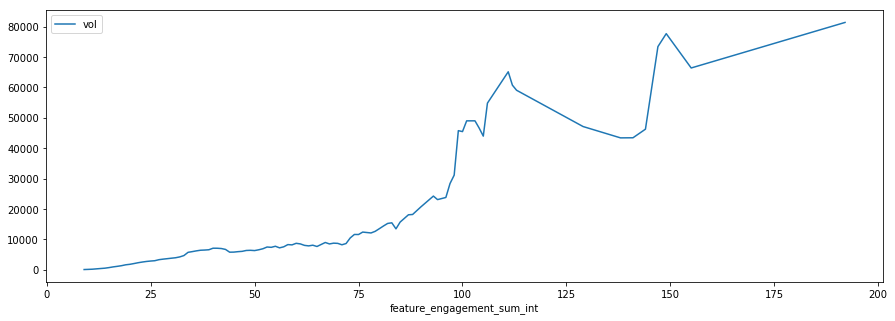

In [45]:
org_lifetime_avg['feature_engagement_sum_int'] = org_lifetime_avg['feature_engagement_sum'].astype(int)
org_lifetime_avg[org_lifetime_avg['org']!=0].groupby('feature_engagement_sum_int')['vol'].median().rolling(10).mean().reset_index().plot(x="feature_engagement_sum_int", y="vol", figsize=(15,5))

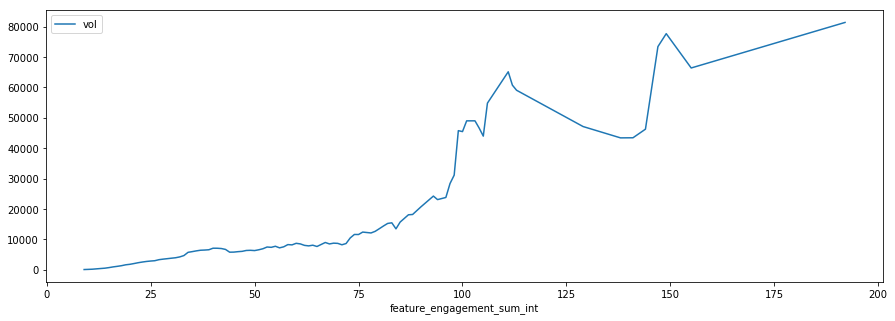

In [46]:
ax = org_lifetime_avg[org_lifetime_avg['org']!=0].groupby('feature_engagement_sum_int')['vol'].median().rolling(10).mean().reset_index().plot(x="feature_engagement_sum_int", y="vol", figsize=(15,5))
ax.figure.savefig("feature_engagement_vol.png")

In [47]:
org_engagement_df = []
for _, r in org_lifetime_avg[['org', 'vol'] + ftr_cols].iterrows():
    for ftr in ftr_cols:
        if r[ftr] > 0.:
            r[ftr] = 1
        else:
            r[ftr] = 0
    org_engagement_df.append(r[['org', 'vol'] + ftr_cols])
org_engagement_df = pd.DataFrame(org_engagement_df)
org_engagement_df['engagement_sum'] = org_engagement_df.drop(['org', 'vol'], axis=1).sum(axis=1)
org_engagement_df[['org', 'engagement_sum', 'vol']].head()

,org,engagement_sum,vol
0,0.0,11.0,0.000000
1,6.0,20.0,10261.816154
2,9.0,19.0,0.804286
3,13.0,21.0,5836.273125
4,31.0,12.0,2393.046154


In [48]:
engagement_ranges = [(0, 5), (5, 7), (7, 8), (8, 10), (10, 12), (12, 16), (16, 25)]

print("Unweighted engagement")
print("| Engagement range | Mean vol | Median vol | Org count |")
print("|-----|:-------:|:--------:|:----------:|")
for r in engagement_ranges:
    this_range = org_engagement_df[(org_engagement_df['org']!=0)&(org_engagement_df['engagement_sum']>=r[0])&(org_engagement_df['engagement_sum']<r[1])]
    print("| {} | \${:,.2f} | \${:,.2f} | {} |".format(r, this_range['vol'].mean(), this_range['vol'].median(), len(this_range)))

Unweighted engagement
| Engagement range | Mean vol | Median vol | Org count |
|-----|:-------:|:--------:|:----------:|
| (0, 5) | \$266.98 | \$0.33 | 267 |
| (5, 7) | \$239.68 | \$0.25 | 683 |
| (7, 8) | \$646.38 | \$62.33 | 438 |
| (8, 10) | \$20,058.08 | \$401.01 | 904 |
| (10, 12) | \$3,331.21 | \$1,059.24 | 774 |
| (12, 16) | \$7,605.99 | \$2,807.73 | 799 |
| (16, 25) | \$15,492.80 | \$6,381.70 | 187 |


Unweighted engagement

| Engagement range | Mean vol | Median vol | Org count |
|-----|:-------:|:--------:|:----------:|
| (0, 5) | \$266.98 | \$0.33 | 267 |
| (5, 7) | \$237.39 | \$0.25 | 681 |
| (7, 8) | \$646.96 | \$62.50 | 435 |
| (8, 10) | \$20,037.04 | \$400.09 | 905 |
| (10, 12) | \$3,321.83 | \$1,056.78 | 777 |
| (12, 16) | \$7,605.29 | \$2,807.73 | 799 |
| (16, 25) | \$15,413.37 | \$6,345.57 | 188 |

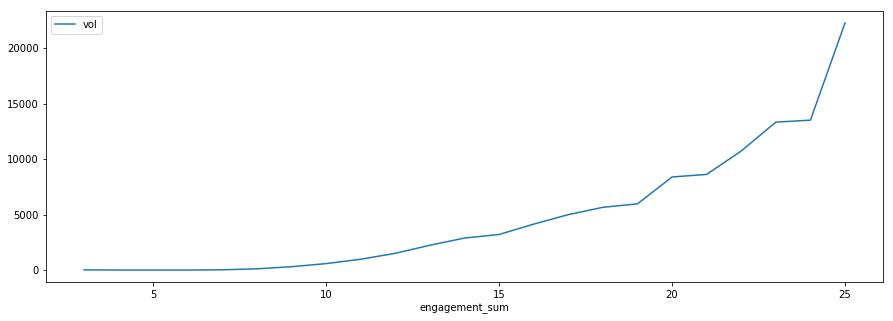

In [49]:
ax = org_engagement_df[org_engagement_df['org']!=0].groupby('engagement_sum')['vol'].median().rolling(3).mean().reset_index().plot(x="engagement_sum", y="vol", figsize=(15,5))
ax.figure.savefig("unweighted_engagement_vol.png")

In [51]:
org_engagement_df[org_engagement_df['org']!=0].to_csv("org_feature_engagement.csv", index=False)
org_engagement_df.head()

,org,vol,users_created,logins,integrations,page_updates,widgets_created,goals_saved,fundhub_builder_accessed,event_builder_accessed,...,source_mobilevt,source_sms,source_fb,source_givi,recurring,donorlogins,logins_six_months,logins_three_months,logins_one_months,engagement_sum
0,0.0,0.000000,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,11.0
1,6.0,10261.816154,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
2,9.0,0.804286,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,19.0
3,13.0,5836.273125,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0
4,31.0,2393.046154,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,12.0
